# 🩺 PCA Visualization — Combined UCI Heart Dataset
This notebook performs **Principal Component Analysis (PCA)** on the 14 core medical features of the combined heart disease dataset.  
It helps visualize how patients separate in low-dimensional space and which physiological factors dominate each principal component.


In [4]:
import warnings
warnings.filterwarnings("ignore")
import os, joblib, pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

%matplotlib inline
plt.style.use("seaborn-v0_8-whitegrid")
sns.set_palette("deep")

BASE_DIR=os.path.abspath(os.path.join(os.getcwd(),".."))
PROCESSED_DIR=os.path.join(BASE_DIR,"data","processed")
dataset_name="combined_uci_heart"

X=joblib.load(os.path.join(PROCESSED_DIR,f"{dataset_name}_X.joblib"))
y=joblib.load(os.path.join(PROCESSED_DIR,f"{dataset_name}_y.joblib"))
if hasattr(X,"toarray"): X=X.toarray()

uci_columns=["age","sex","cp","trestbps","chol","fbs","restecg",
             "thalach","exang","oldpeak","slope","ca","thal","target_placeholder"]
ncols=X.shape[1]
columns=uci_columns[:min(14,ncols)]+[f"feat_{i}" for i in range(14,ncols)]
df=pd.DataFrame(X,columns=columns[:ncols])
df["target"]=y

core_features=[c for c in df.columns if c in uci_columns[:14]]
print("✅ Loaded dataset with",len(core_features),"core features and target.")


✅ Loaded dataset with 13 core features and target.


## ⚙️ Standardization and PCA Computation

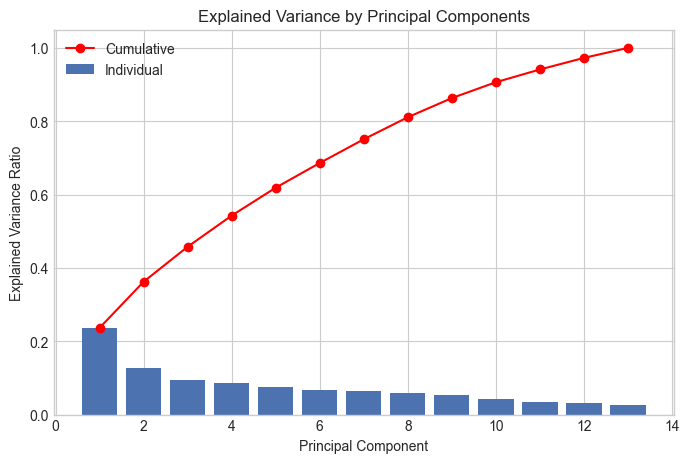

In [5]:
scaler=StandardScaler()
X_scaled=scaler.fit_transform(df[core_features])
pca=PCA(n_components=len(core_features))
pca.fit(X_scaled)

explained=pca.explained_variance_ratio_
cum_explained=np.cumsum(explained)

plt.figure(figsize=(8,5))
plt.bar(range(1,len(explained)+1),explained,label="Individual")
plt.plot(range(1,len(cum_explained)+1),cum_explained,marker="o",color="red",label="Cumulative")
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.title("Explained Variance by Principal Components")
plt.legend()
plt.show()


## 📊 2D Projection of Patients (PC1 vs PC2)

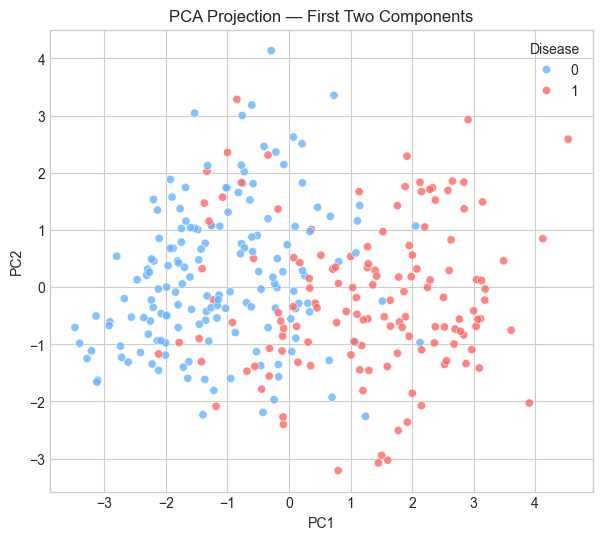

In [6]:
X_pca=pca.transform(X_scaled)
pca_df=pd.DataFrame(X_pca[:,:2],columns=["PC1","PC2"])
pca_df["target"]=df["target"].values

plt.figure(figsize=(7,6))
sns.scatterplot(data=pca_df,x="PC1",y="PC2",hue="target",palette=["#66b3ff","#ff6666"],alpha=0.8)
plt.title("PCA Projection — First Two Components")
plt.legend(title="Disease")
plt.show()


## 🧭 Feature Loadings (Component Contributions)

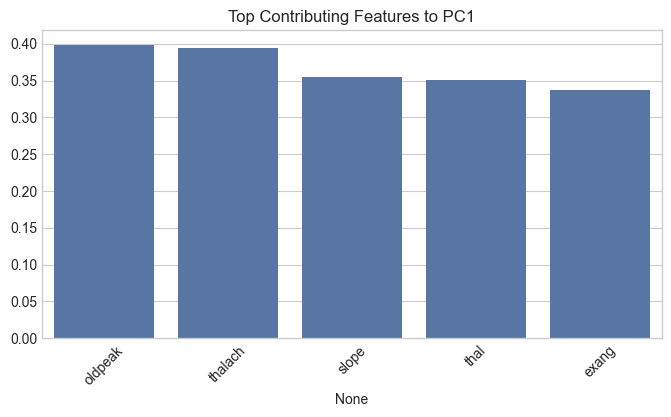

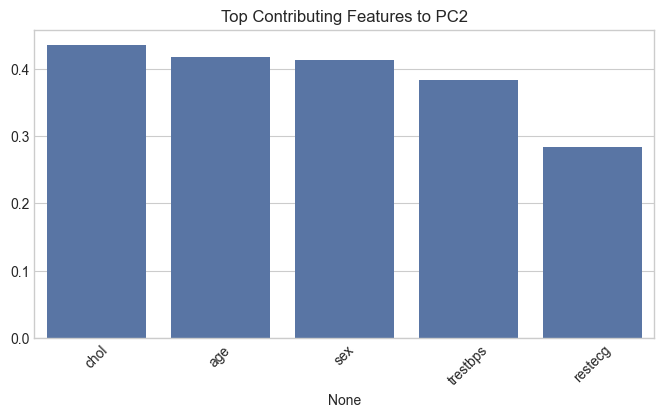

In [7]:
loadings=pd.DataFrame(pca.components_.T,index=core_features,columns=[f"PC{i+1}" for i in range(len(core_features))])
top_features_PC1=loadings["PC1"].abs().sort_values(ascending=False).head(5)
top_features_PC2=loadings["PC2"].abs().sort_values(ascending=False).head(5)

plt.figure(figsize=(8,4))
sns.barplot(x=top_features_PC1.index,y=top_features_PC1.values)
plt.title("Top Contributing Features to PC1")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(8,4))
sns.barplot(x=top_features_PC2.index,y=top_features_PC2.values)
plt.title("Top Contributing Features to PC2")
plt.xticks(rotation=45)
plt.show()


## 🩻 Automated PCA Interpretation

In [8]:
def interpret_pca(loadings,features):
    top1=loadings["PC1"].abs().sort_values(ascending=False).head(3).index.tolist()
    top2=loadings["PC2"].abs().sort_values(ascending=False).head(3).index.tolist()
    text="Based on PCA loadings:\n"
    text+=f"• **PC1** is mainly influenced by: {', '.join(top1)}.\n"
    text+=f"• **PC2** is mainly influenced by: {', '.join(top2)}.\n"
    text+="\nInterpretation:\nPC1 likely represents overall cardiovascular stress or metabolic load, "
    text+="while PC2 may capture exercise tolerance or ECG-related variability."
    return text

print(interpret_pca(loadings,core_features))


Based on PCA loadings:
• **PC1** is mainly influenced by: oldpeak, thalach, slope.
• **PC2** is mainly influenced by: chol, age, sex.

Interpretation:
PC1 likely represents overall cardiovascular stress or metabolic load, while PC2 may capture exercise tolerance or ECG-related variability.
